In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import BaseEstimator, RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Converting Times Series Data to 3D format
from src.utils.split_sequences import split_sequences

# Transformer Encoder for time series data
from src.models.transformer_ts_tf import Transformer

2024-10-28 12:01:52.454054: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 12:01:52.457576: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 12:01:52.530312: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-28 12:01:52.531811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 12:01:53.866953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

# Functions and definitions

### Convert train/test data to 3D format

In [3]:
def generate_sequences_helper(
    dataset, cement_types, dates=None, timesteps=None, split_by_cement_type=False
):
    index_train = dataset["y_train"].index
    index_test = dataset["y_test"].index

    dataset["y_train"] = dataset["y_train"].reset_index(drop=True)
    dataset["y_test"] = dataset["y_test"].reset_index(drop=True)

    if dates is not None:
        dataset["dates_train"] = dates[index_train].reset_index(drop=True)
        dataset["dates_test"] = dates[index_test].reset_index(drop=True)

    dataset["cement_types_train"] = cement_types.loc[index_train].reset_index(drop=True)
    dataset["cement_types_test"] = cement_types.loc[index_test].reset_index(drop=True)

    dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

    return dataset

<IPython.core.display.Javascript object>

In [4]:
def generate_sequences(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        dataset["x_train"], dataset["y_train"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

### Data preprocessing

In [5]:
def impute_data(dataset, imputer=None, imputer_params=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply imputation to the data
    if imputer is not None:
        imputer = imputer() if imputer_params is None else imputer(**imputer_params)
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return dataset

<IPython.core.display.Javascript object>

In [6]:
def transform_data(dataset, transformer=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply data normalization/standardization to the data
    if transformer is not None:
        scaler = transformer()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return dataset

<IPython.core.display.Javascript object>

In [7]:
def preprocess_data(dataset, transformer=None, imputer=None, imputer_params=None):
    dataset = impute_data(dataset, imputer, imputer_params)
    dataset = transform_data(dataset, transformer)
    return dataset

<IPython.core.display.Javascript object>

### Train and evaluate the model

In [8]:
def train_and_evaluate_model(Estimator, dataset, estimator_params=None):
    """
    Purpose: Helper function to be used in conjunction with
    blocked time_series cross validation function
    """
    x_train = dataset["x_train"]
    y_train = dataset["y_train"]
    x_test = dataset["x_test"]
    y_test = dataset["y_test"]

    # Instantiate the model
    model = Estimator() if estimator_params is None else Estimator(estimator_params)

    # Fitting the model
    model.fit(x_train, y_train)

    # Making predictions on train/test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Return regression metrics
    return score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

<IPython.core.display.Javascript object>

### Custom Cross Validate

In [9]:
def custom_cross_validate(
    Estimator,
    Imputer,
    Transform,
    x,
    y,
    cv,
    timesteps,
    dates=None,
    cement_types=None,
    estimator_params=None,
    imputer_params=None,
    split_by_cement_type=True,
):
    results = []
    scores = []

    for train_index, test_index in cv.split(x):
        dataset = {
            "dates_train": dates[train_index].reset_index(drop=True),
            "cement_types_train": cement_types.loc[train_index].reset_index(drop=True),
            "x_train": x.loc[train_index].reset_index(drop=True),
            "y_train": y[train_index].reset_index(drop=True),
            "dates_test": dates[test_index].reset_index(drop=True),
            "cement_types_test": cement_types.loc[test_index].reset_index(drop=True),
            "x_test": x.loc[test_index].reset_index(drop=True),
            "y_test": y[test_index].reset_index(drop=True),
        }

        # Preprocess the dataset
        dataset = preprocess_data(dataset, Transform, Imputer, imputer_params)

        # generate sequences (3D format)
        dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

        # Train and Evaluate the model
        score = train_and_evaluate_model(Estimator, dataset, estimator_params)
        scores.append(score)

    # After every iteration metrics results are appended together
    scores_final = {key: [] for key, _ in scores[0].items()}
    for scores_dict in scores:
        for key, value in scores_dict.items():
            scores_final[key] += [value]
    results.append(scores_final)
    return results

<IPython.core.display.Javascript object>

## Model Definition

In [10]:
class TransformerWrapper(RegressorMixin):
    def __init__(self, params):
        self.params = params
        self.model = self.get_model()
        self.batch_size = self.params.get("batch_size", 16)
        self.epochs = self.params.get("epochs", 300)
        self.verbose = self.params.get("verbose", 0)
        self.callbacks = self.params.get("callbacks", None)
        self.validation_split = self.params.get("validation_split", 0.0)
        self.num_features = self.params.get("num_features", x.shape[-1])

    def fit(self, X=None, y=None):
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = Transformer(
            num_hid=self.params["num_features"],
            time_steps=self.params["timesteps"],
            num_head=self.params["num_heads"],
            num_layers_enc=self.params["num_layers_enc"],
            num_feed_forward=self.params["num_feed_forward"],
            dropout_rate=self.params.get("dropout_rate", 0.1),
            activation=self.params.get("activation", "relu"),
        )
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

<IPython.core.display.Javascript object>

In [11]:
def pad_time_series(dataframe, timesteps):
    """
    Pad timeseries with zeros
    """
    df_tmp = pd.DataFrame(
        dict(
            zip(
                dataframe.columns,
                [[0 for _ in range(timesteps - 1)] for _ in range(dataframe.shape[1])],
            )
        )
    )
    df_tmp[DATE] = dataframe[DATE].iloc[0]
    return pd.concat([df_tmp, dataframe], axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [12]:
def split_sequences_per_cement_type(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        return split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())

    return x, y

<IPython.core.display.Javascript object>

# Settings for Reproducibility

In [13]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [14]:
def set_global_determinism():
    set_seeds(seed=SEED)

    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

<IPython.core.display.Javascript object>

In [15]:
index_to_save = 10
model_index = 1

<IPython.core.display.Javascript object>

In [16]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}
DATE = "Date"
CEMENT_TYPES = [
    "Cement_Type_CP I-S-40",
    "Cement_Type_CP II-E-32",
    "Cement_Type_CP II-E-40",
    "Cement_Type_CP II-F-32",
    "Cement_Type_CP II-F-40",
    "Cement_Type_CP II-Z-32",
    "Cement_Type_CP II-Z-40",
    "Cement_Type_CP III-32",
    "Cement_Type_CP III-32 RS",
    "Cement_Type_CP III-40",
    "Cement_Type_CP III-40 RS",
    "Cement_Type_CP IV-32",
    "Cement_Type_CP IV-32 RS",
    "Cement_Type_CP V-ARI",
    "Cement_Type_CP V-ARI RS",
    "Cement_Type_Fibrocimento",
    # "Cement_Type_Type I-II",
    # "Cement_Type_Type III",
    # "Cement_Type_Type IL",
    "Cement_Type_CP I-40",
]

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [17]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "203",
    "Plant": "C",
    "Features": "Chemical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Transformer",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [18]:
df = pd.read_csv("../../../../../../../data/processed/203/global_c.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we use all available features

In [19]:
df_copy = df.copy().drop(
    [
        "Factory_Plant",
        # "CS1",
        "CS3",
        "CS7",
    ],
    axis=1,
)
df_copy = pd.get_dummies(data=df_copy, columns=["Cement_Type"], drop_first=True)

<IPython.core.display.Javascript object>

In [20]:
df_copy[CEMENT_TYPES] = df_copy[CEMENT_TYPES].astype(int)
dates = df["Date"].copy()
x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
y = df_copy["CS28"]

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [21]:
def prepare_dataset(
    dataframe_original=df,
    dataframe_copy=df_copy,
    train_size=0.8,
    test_size=0.2,
    ignore_test_set=False,
    timesteps=1,
    split_by_cement_type=True,
):
    dataframe_original = df.copy()
    dataframe_copy = df_copy.copy()
    dataframe_copy[CEMENT_TYPES] = dataframe_copy[CEMENT_TYPES].astype(int).copy()
    dates = dataframe_original["Date"].copy()
    x = dataframe_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
    y = dataframe_copy["CS28"]
    cement_types = dataframe_copy[CEMENT_TYPES].copy()

    if not ignore_test_set:
        train_index = x.loc[: x.shape[0] * train_size].index
        test_index = x.loc[train_index[-1] + 1 :].index
    else:
        train_index = x.loc[: x.shape[0] * train_size].index
        test_index = x.loc[train_index[-1] + 1 :].index

    dataset = {
        "dates_train": dates[train_index].reset_index(drop=True).copy(),
        "cement_types_train": cement_types.loc[train_index]
        .reset_index(drop=True)
        .copy(),
        "x_train": x.loc[train_index].reset_index(drop=True).copy(),
        "y_train": y[train_index].reset_index(drop=True).copy(),
        "dates_test": dates[test_index].reset_index(drop=True).copy(),
        "cement_types_test": cement_types.loc[test_index].reset_index(drop=True).copy(),
        "x_test": x.loc[test_index].reset_index(drop=True).copy(),
        "y_test": y[test_index].reset_index(drop=True).copy(),
    }

    # Preprocess the dataset
    dataset = preprocess_data(dataset, None, SimpleImputer, {"strategy": "median"})

    # generate sequences (3D format)
    dataset = generate_sequences(
        dataset, timesteps=timesteps, split_by_cement_type=split_by_cement_type
    )

    return dataset

<IPython.core.display.Javascript object>

In [22]:
def get_transformer_params(
    timesteps=1,
    num_features=x.shape[-1],
    num_heads=1,
    num_layers_enc=1,
    num_feed_forward=16,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=None,
    validation_split=0.0,
    verbose=0,
):
    params = {}
    params["num_features"] = x.shape[-1]
    params["timesteps"] = timesteps
    params["num_heads"] = num_heads
    params["num_layers_enc"] = num_layers_enc
    params["num_feed_forward"] = num_feed_forward
    params["verbose"] = verbose
    params["dropout_rate"] = dropout_rate
    params["activation"] = activation
    params["batch_size"] = batch_size
    params["epochs"] = epochs
    params["callbacks"] = callbacks
    params["validation_split"] = validation_split

    return params

<IPython.core.display.Javascript object>

In [23]:
TIMESTEPS_LIST = [1, 7, 14]

<IPython.core.display.Javascript object>

# Transformer Encoder

### Transformer 1

1. TIMESTEPS: 1

In [24]:
set_seeds()
timesteps = 1
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=5,
    num_layers_enc=1,
    num_feed_forward=32,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

2024-10-28 12:01:58.921559: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-28 12:01:58.921615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: inspirada
2024-10-28 12:01:58.921626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: inspirada
2024-10-28 12:01:58.921859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-10-28 12:01:58.921885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-10-28 12:01:58.921891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


Minutes Elapsed:  4.321627652645111


<IPython.core.display.Javascript object>

In [25]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.044 (0.000)
MAE: 2.347 (0.000)
MAPE: 0.054 (0.000)
R2: 0.801 (0.000)


******
[TEST]
******
RMSE: 3.002 (0.000)
MAE: 2.273 (0.000)
MAPE: 0.055 (0.000)
R2: 0.750 (0.000)




<IPython.core.display.Javascript object>

In [26]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 1

1. TIMESTEPS: 7

In [27]:
set_seeds()
timesteps = 7
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=5,
    num_layers_enc=1,
    num_feed_forward=32,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  3.618186954657237


<IPython.core.display.Javascript object>

In [28]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.675 (0.000)
MAE: 2.961 (0.000)
MAPE: 0.068 (0.000)
R2: 0.711 (0.000)


******
[TEST]
******
RMSE: 3.750 (0.000)
MAE: 3.047 (0.000)
MAPE: 0.073 (0.000)
R2: 0.610 (0.000)




<IPython.core.display.Javascript object>

In [29]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 1

1. TIMESTEPS: 14

In [30]:
set_seeds()
timesteps = 14
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=5,
    num_layers_enc=1,
    num_feed_forward=32,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  3.3287466843922933


<IPython.core.display.Javascript object>

In [31]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.587 (0.000)
MAE: 2.879 (0.000)
MAPE: 0.066 (0.000)
R2: 0.725 (0.000)


******
[TEST]
******
RMSE: 3.570 (0.000)
MAE: 2.890 (0.000)
MAPE: 0.069 (0.000)
R2: 0.647 (0.000)




<IPython.core.display.Javascript object>

In [32]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 2

1. TIMESTEPS: 1

In [33]:
set_seeds()
timesteps = 1
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=5,
    num_layers_enc=1,
    num_feed_forward=128,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  3.09087975025177


<IPython.core.display.Javascript object>

In [34]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 5.250 (0.000)
MAE: 4.291 (0.000)
MAPE: 0.103 (0.000)
R2: 0.409 (0.000)


******
[TEST]
******
RMSE: 5.800 (0.000)
MAE: 4.963 (0.000)
MAPE: 0.121 (0.000)
R2: 0.066 (0.000)




<IPython.core.display.Javascript object>

In [35]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 2

1. TIMESTEPS: 7

In [36]:
set_seeds()
timesteps = 7
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=5,
    num_layers_enc=1,
    num_feed_forward=128,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  5.066472899913788


<IPython.core.display.Javascript object>

In [37]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.364 (0.000)
MAE: 2.666 (0.000)
MAPE: 0.061 (0.000)
R2: 0.758 (0.000)


******
[TEST]
******
RMSE: 3.371 (0.000)
MAE: 2.685 (0.000)
MAPE: 0.065 (0.000)
R2: 0.685 (0.000)




<IPython.core.display.Javascript object>

In [38]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 2

1. TIMESTEPS: 14

In [39]:
set_seeds()
timesteps = 14
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=5,
    num_layers_enc=1,
    num_feed_forward=128,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  11.815282046794891


<IPython.core.display.Javascript object>

In [40]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.395 (0.000)
MAE: 2.714 (0.000)
MAPE: 0.063 (0.000)
R2: 0.753 (0.000)


******
[TEST]
******
RMSE: 3.303 (0.000)
MAE: 2.589 (0.000)
MAPE: 0.063 (0.000)
R2: 0.698 (0.000)




<IPython.core.display.Javascript object>

In [41]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 3

1. TIMESTEPS: 1

In [42]:
set_seeds()
timesteps = 1
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=3,
    num_layers_enc=4,
    num_feed_forward=256,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  23.868914357821147


<IPython.core.display.Javascript object>

In [43]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.837 (0.000)
MAE: 2.159 (0.000)
MAPE: 0.049 (0.000)
R2: 0.827 (0.000)


******
[TEST]
******
RMSE: 3.076 (0.000)
MAE: 2.249 (0.000)
MAPE: 0.054 (0.000)
R2: 0.737 (0.000)




<IPython.core.display.Javascript object>

In [44]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 3

1. TIMESTEPS: 7

In [45]:
set_seeds()
timesteps = 7
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=3,
    num_layers_enc=4,
    num_feed_forward=256,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  15.101416309674581


<IPython.core.display.Javascript object>

In [46]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.407 (0.000)
MAE: 2.670 (0.000)
MAPE: 0.060 (0.000)
R2: 0.751 (0.000)


******
[TEST]
******
RMSE: 3.057 (0.000)
MAE: 2.419 (0.000)
MAPE: 0.058 (0.000)
R2: 0.741 (0.000)




<IPython.core.display.Javascript object>

In [47]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 3

1. TIMESTEPS: 14

In [48]:
set_seeds()
timesteps = 14
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=3,
    num_layers_enc=4,
    num_feed_forward=256,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  26.388713999589285


<IPython.core.display.Javascript object>

In [49]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.318 (0.000)
MAE: 2.592 (0.000)
MAPE: 0.059 (0.000)
R2: 0.764 (0.000)


******
[TEST]
******
RMSE: 3.012 (0.000)
MAE: 2.338 (0.000)
MAPE: 0.055 (0.000)
R2: 0.749 (0.000)




<IPython.core.display.Javascript object>

In [50]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 4

1. TIMESTEPS: 1

In [51]:
set_seeds()
timesteps = 1
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=4,
    num_layers_enc=2,
    num_feed_forward=128,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  11.543990659713746


<IPython.core.display.Javascript object>

In [52]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.164 (0.000)
MAE: 2.355 (0.000)
MAPE: 0.055 (0.000)
R2: 0.785 (0.000)


******
[TEST]
******
RMSE: 3.313 (0.000)
MAE: 2.474 (0.000)
MAPE: 0.060 (0.000)
R2: 0.695 (0.000)




<IPython.core.display.Javascript object>

In [53]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 4

1. TIMESTEPS: 7

In [54]:
set_seeds()
timesteps = 7
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=4,
    num_layers_enc=2,
    num_feed_forward=128,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  10.22582976023356


<IPython.core.display.Javascript object>

In [55]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.141 (0.000)
MAE: 2.478 (0.000)
MAPE: 0.057 (0.000)
R2: 0.789 (0.000)


******
[TEST]
******
RMSE: 3.032 (0.000)
MAE: 2.373 (0.000)
MAPE: 0.057 (0.000)
R2: 0.745 (0.000)




<IPython.core.display.Javascript object>

In [56]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 4

1. TIMESTEPS: 14

In [57]:
set_seeds()
timesteps = 14
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=4,
    num_layers_enc=2,
    num_feed_forward=128,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  11.247698986530304


<IPython.core.display.Javascript object>

In [58]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.304 (0.000)
MAE: 2.599 (0.000)
MAPE: 0.060 (0.000)
R2: 0.766 (0.000)


******
[TEST]
******
RMSE: 3.313 (0.000)
MAE: 2.595 (0.000)
MAPE: 0.062 (0.000)
R2: 0.696 (0.000)




<IPython.core.display.Javascript object>

In [59]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 5

1. TIMESTEPS: 1

In [60]:
set_seeds()
timesteps = 1
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=7,
    num_layers_enc=2,
    num_feed_forward=64,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  17.984352564811708


<IPython.core.display.Javascript object>

In [61]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.613 (0.000)
MAE: 1.950 (0.000)
MAPE: 0.044 (0.000)
R2: 0.854 (0.000)


******
[TEST]
******
RMSE: 2.739 (0.000)
MAE: 2.075 (0.000)
MAPE: 0.049 (0.000)
R2: 0.792 (0.000)




<IPython.core.display.Javascript object>

In [62]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 5

1. TIMESTEPS: 7

In [63]:
set_seeds()
timesteps = 7
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=7,
    num_layers_enc=2,
    num_feed_forward=64,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  8.798153813680013


<IPython.core.display.Javascript object>

In [64]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 4.218 (0.000)
MAE: 3.299 (0.000)
MAPE: 0.072 (0.000)
R2: 0.619 (0.000)


******
[TEST]
******
RMSE: 3.668 (0.000)
MAE: 2.912 (0.000)
MAPE: 0.066 (0.000)
R2: 0.627 (0.000)




<IPython.core.display.Javascript object>

In [65]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

### Transformer 5

1. TIMESTEPS: 14

In [66]:
set_seeds()
timesteps = 14
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)
x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=7,
    num_layers_enc=2,
    num_feed_forward=64,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=model_early_stop,
    validation_split=0.1,
    verbose=0,
)

start = time.time()
scores = train_and_evaluate_model(TransformerWrapper, dataset, estimator_params=params)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  8.639511704444885


<IPython.core.display.Javascript object>

In [67]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 3.714 (0.000)
MAE: 2.998 (0.000)
MAPE: 0.071 (0.000)
R2: 0.705 (0.000)


******
[TEST]
******
RMSE: 3.737 (0.000)
MAE: 3.050 (0.000)
MAPE: 0.075 (0.000)
R2: 0.613 (0.000)




<IPython.core.display.Javascript object>

In [68]:
results_dict_copy = results_dict.copy()
results_dict_copy["Timesteps"] = timesteps
results_dict_copy["Cross Validation"] = "Out of time"
results_dict_copy["Cross Validation Params"] = '{"train_size": 0.8, "test_size": 0.2}'
results_dict_copy["Data Shape"] = x.shape
results_dict_copy["Model"] = f"Transformer_{model_index}"
scores = {key: [value] for key, value in scores.items()}
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)
model_index += 1

<IPython.core.display.Javascript object>

# Saving the results

In [71]:
path = f"../../../../../../../reports/results/global_models/203/c/pre_training/full/"
filename = f"transformer_results_full_{index_to_save}.csv"

pd.concat(results_to_save).to_csv(
    path_or_buf=path + filename,
    mode="w",
    index=False,
    header=True,
)

<IPython.core.display.Javascript object>

In [72]:
# Concatenating the results
ddf = pd.concat(results_to_save).reset_index(drop=True)
ddf_copy = ddf.copy()

# Define the columns to standardize
cols = ["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"]

# Standardize all the metrics including R²
scaler = StandardScaler()
standardized_metrics = scaler.fit_transform(ddf_copy[cols])

# Creating a new DataFrame with standardized values
standardized_df = pd.DataFrame(
    standardized_metrics,
    columns=cols,
)

# Summing all standardized metrics and subtracting the standardized R2
standardized_df["Result"] = (
    standardized_df["RMSE Test"]
    + standardized_df["MAE Test"]
    + standardized_df["MAPE Test"]
    - standardized_df["R2 Test"]
)

# Update the SCPM in ddf_copy
ddf_copy["SCPM"] = standardized_df["Result"]

# Finding the row with the minimum SCPM value
optimal_row = ddf_copy[ddf_copy["SCPM"].eq(ddf_copy["SCPM"].min())]

# Display the result
optimal_row

,Category,Company,Plant,Features,Data Shape,Timesteps,Model,Model Params,Scaler,Scaler Params,...,Cross Validation Params,RMSE Train,MAE Train,MAPE Train,R2 Train,RMSE Test,MAE Test,MAPE Test,R2 Test,SCPM
12,Global Model,203,C,Chemical + Properties CS Less,"(64225, 15)",1,Transformer_13,None,Standard Scaler,None,...,"{""train_size"": 0.8, ""test_size"": 0.2}",2.612861,1.950102,0.044482,0.853673,2.73873,2.075461,0.049453,0.791741,-3.802709


<IPython.core.display.Javascript object>

# Pre train best model for fine tuning

### Transformer 5

1. TIMESTEPS: 1

In [73]:
set_seeds()
timesteps = 1
model_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
dataset = prepare_dataset(timesteps=timesteps)


x_train = dataset["x_train"]
y_train = dataset["y_train"]
x_test = dataset["x_test"]
y_test = dataset["y_test"]

x_train = np.concatenate([x_train, x_test])
y_train = np.concatenate([y_train, y_test])

params = get_transformer_params(
    timesteps=timesteps,
    num_features=x.shape[-1],
    num_heads=7,
    num_layers_enc=2,
    num_feed_forward=64,
    dropout_rate=0.1,
    activation="relu",
    batch_size=64,
    epochs=300,
    callbacks=None,
    validation_split=0.0,
    verbose=0,
)

start = time.time()
# Instantiate the model
model = TransformerWrapper(params)
# Fitting the model
model.fit(x_train, y_train)
end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Minutes Elapsed:  67.35237298806508


<IPython.core.display.Javascript object>

In [74]:
# Making predictions on train/test sets
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_train)
scores = score_regression_metrics(y_train, y_train_pred, y_train, y_test_pred)

<IPython.core.display.Javascript object>

In [75]:
print_scores(scores, METRICS, METRICS_DICT)

******
[TRAIN]
******
RMSE: 2.154 (0.000)
MAE: 1.622 (0.000)
MAPE: 0.037 (0.000)
R2: 0.897 (0.000)


******
[TEST]
******
RMSE: 2.154 (0.000)
MAE: 1.622 (0.000)
MAPE: 0.037 (0.000)
R2: 0.897 (0.000)




<IPython.core.display.Javascript object>

In [76]:
weights_path = (
    "../../../../../../../models/global_models/203/transformer/c/pre_training/"
)
model_name = "transformer_chemical_properties_csless_vars_weights.h5"

<IPython.core.display.Javascript object>

In [77]:
full_path = os.path.join(weights_path, model_name)
model.model.save_weights(full_path)

<IPython.core.display.Javascript object>

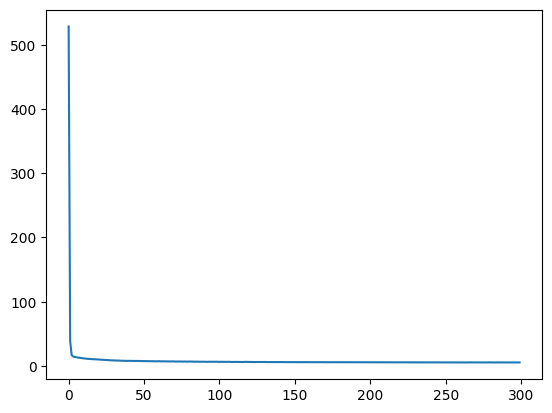

<IPython.core.display.Javascript object>

In [78]:
import matplotlib.pyplot as plt

plt.plot(model.history.history["loss"])

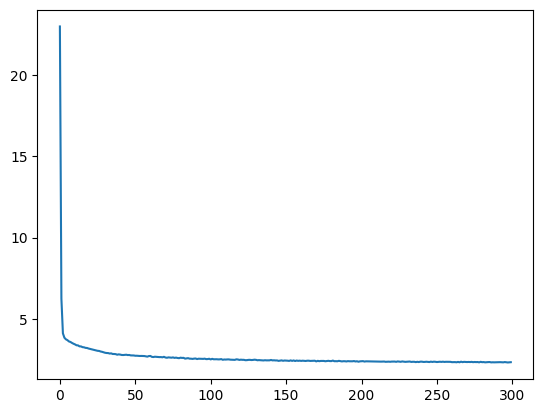

<IPython.core.display.Javascript object>

In [79]:
plt.plot(model.history.history["RMSE"])

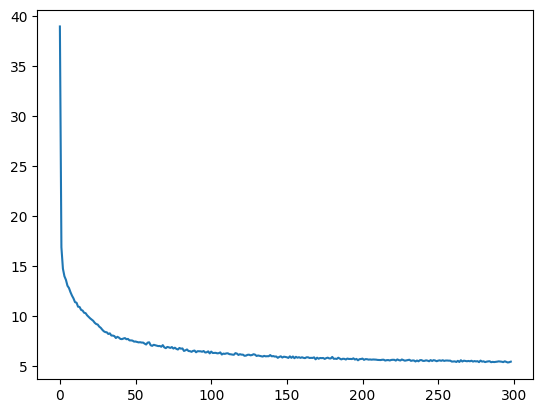

<IPython.core.display.Javascript object>

In [80]:
plt.plot(model.history.history["loss"][1:])

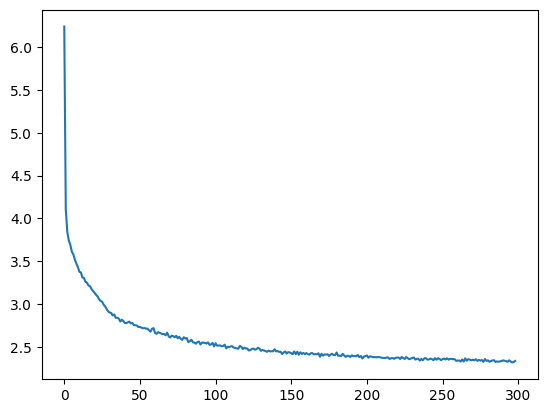

<IPython.core.display.Javascript object>

In [81]:
plt.plot(model.history.history["RMSE"][1:])

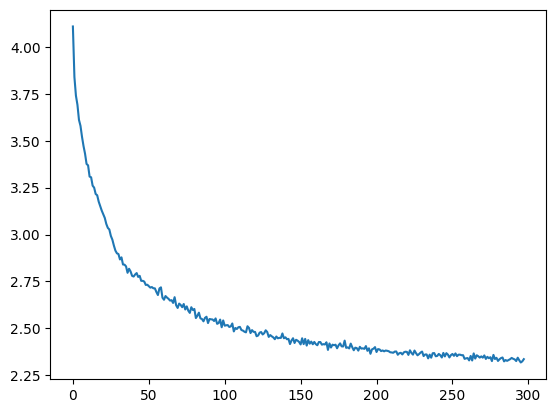

<IPython.core.display.Javascript object>

In [82]:
plt.plot(model.history.history["RMSE"][2:])